In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import time

In [2]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams.update({'font.size': 22})
plt.rcParams['axes.titlepad'] = 30
plt.rcParams['axes.labelpad'] = 20

In [3]:
import os
if (os.system("cl.exe")):
    os.environ['PATH'] += ';'+r"C:\Program Files (x86)\Microsoft Visual Studio\2017\Community\VC\Tools\MSVC\14.16.27023\bin\Hostx64\x64"

## CPU (NUMBA)

In [4]:
import numba
import math

@numba.njit
def _cpu_bilinear_interpolate(x, y, image, size):
    
    i1 = math.floor(image.shape[1] * (x - size[0]) / (size[1] - size[0]) - 0.5)
    i2 = i1 + 1
    j1 = math.floor(image.shape[0] * (y - size[2]) / (size[3] - size[2]) - 0.5)
    j2 = j1 + 1
    
    # interpolate in x
    t = (x - size[0]) / (size[1] - size[0]) * image.shape[1] - i1 - 0.5
    u = (y - size[2]) / (size[3] - size[2]) * image.shape[0] - j1 - 0.5
    
    # left edge
    if i1 < 0:
        i1 = 0
        i2 = i1
        t = 0.5
    # right edge
    if i2 > image.shape[1] - 1:
        i2 = image.shape[1] - 1
        i1 = i2
        t = 0.5
        
    # bottom edge
    if j1 < 0:
        j1 = 0
        j2 = j1
        u = 0.5
    # top edge
    if j2 > image.shape[0] - 1:
        j2 = image.shape[0] - 1
        j1 = j2
        u = 0.5
        
    # bilinear interpolation
    z = image[j1, i1] * (1 - t) * (1 - u) + image[j2, i2] * t * u + image[j1, i2] * t * (1 - u) + image[j2, i1] * (1 - t) * u
    
    return z

@numba.njit
def cpu_bilinear_interpolate(xs, ys, image, size, out):
    for i in range(xs.shape[0]):
        out[i] = _cpu_bilinear_interpolate(xs[i], ys[i], image, size)

@numba.njit(parallel=True)
def cpu_parallel_bilinear_interpolate(xs, ys, image, size, out):
    for i in numba.prange(xs.shape[0]):
        out[i] = _cpu_bilinear_interpolate(xs[i], ys[i], image, size)

## CUDA (PyCUDA)

In [7]:
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

def cuda_bilinear_interpolate(xs, ys, zs, image, extent):
    mod = SourceModule("""
        __global__ void bilinear_interpolate(float *xs, float *ys, float *zs, int nxy, float *image, int nx, int ny, float minx, float maxx, float miny, float maxy)
        {
            int cu_x = threadIdx.x + blockIdx.x * blockDim.x;
            int cu_y = threadIdx.y + blockIdx.y * blockDim.y;
            int offset = cu_x + cu_y * blockDim.x * gridDim.x;

            if (offset >= nxy)
            {
                return;
            }
            
            float x = xs[offset];
            float y = ys[offset];

            int i1 = int(floorf(nx * (x - minx) / (maxx - minx) - 0.5));
            int i2 = i1 + 1;
            int j1 = int(floorf(ny * (y - miny) / (maxy - miny) - 0.5));
            int j2 = j1 + 1;

            // interpolate in x
            float t = (x - minx) / (maxx - minx) * nx - i1 - 0.5;
            float u = (y - miny) / (maxy - miny) * ny - j1 - 0.5;
            // left edge
            if (i1 < 0)
            {
                i1 = 0;
                i2 = i1;
                t = 0.5;
            }
            // right edge
            if (i2 > (nx - 1))
            {
                i2 = nx - 1;
                i1 = i2;
                t = 0.5;
            }
            // bottom edge
            if (j1 < 0)
            {
                j1 = 0;
                j2 = j1;
                u = 0.5;
            }
            // top edge
            if (j2 > (ny - 1))
            {
                j2 = ny - 1;
                j1 = j2;
                u = 0.5;
            }

            // bilinear interpolation
            float z = 0;
            z += image[j1 * nx + i1] * (1 - t) * (1 - u);
            z += image[j2 * nx + i2] * t * u;
            z += image[j1 * nx + i2] * t * (1 - u);
            z += image[j2 * nx + i1] * (1 - t) * u;
            zs[offset] = z;
        }
    """)

    func = mod.get_function("bilinear_interpolate")
    threads_per_block = 512
    nblocks = xs.shape[0] // threads_per_block + 1

    xs_d = cuda.In(xs)
    ys_d = cuda.In(ys)
    zs_h = cuda.Out(zs)
    nxy = np.int32(np.size(xs))
    image_d = cuda.In(image)
    nx = np.int32(image.shape[1])
    ny = np.int32(image.shape[0])
    minx = np.float32(extent[0])
    maxx = np.float32(extent[1]) 
    miny = np.float32(extent[2])
    maxy = np.float32(extent[3])
    block=(threads_per_block, 1, 1)
    grid=(nblocks, 1, 1)
    
    start_time = time.time()
    func(xs_d, ys_d, zs_h, nxy, image_d, nx, ny, minx, maxx, miny, maxy, block=block, grid=grid)
    elapsed_time = time.time() - start_time
    
    return elapsed_time


def cuda_tex_bilinear_interpolate(xs, ys, zs, image, extent):
    mod = SourceModule("""
        texture<float, 2> image;
    
        __global__ void tex_bilinear_interpolate(float *xs, float *ys, float *zs, int nxy, int nx, int ny, float minx, float maxx, float miny, float maxy)
        {
            int cu_x = threadIdx.x + blockIdx.x * blockDim.x;
            int cu_y = threadIdx.y + blockIdx.y * blockDim.y;
            int offset = cu_x + cu_y * blockDim.x * gridDim.x;

            if (offset >= nxy)
            {
                return;
            }
            
            float x = xs[offset];
            float y = ys[offset];

            int i1 = int(floorf(nx * (x - minx) / (maxx - minx) - 0.5));
            int i2 = i1 + 1;
            int j1 = int(floorf(ny * (y - miny) / (maxy - miny) - 0.5));
            int j2 = j1 + 1;

            // interpolate in x
            float t = (x - minx) / (maxx - minx) * nx - i1 - 0.5;
            float u = (y - miny) / (maxy - miny) * ny - j1 - 0.5;
            // left edge
            if (i1 < 0)
            {
                i1 = 0;
                i2 = i1;
                t = 0.5;
            }
            // right edge
            if (i2 > (nx - 1))
            {
                i2 = nx - 1;
                i1 = i2;
                t = 0.5;
            }
            // bottom edge
            if (j1 < 0)
            {
                j1 = 0;
                j2 = j1;
                u = 0.5;
            }
            // top edge
            if (j2 > (ny - 1))
            {
                j2 = ny - 1;
                j1 = j2;
                u = 0.5;
            }

            // bilinear interpolation
            float z = 0;
            z += tex2D(image, i1, j1) * (1 - t) * (1 - u);
            z += tex2D(image, i2, j2) * t * u;
            z += tex2D(image, i2, j1) * t * (1 - u);
            z += tex2D(image, i1, j2) * (1 - t) * u;
            zs[offset] = z;
        }
    """)

    func = mod.get_function("tex_bilinear_interpolate")
    tex_image = mod.get_texref("image")
    
    cuda.matrix_to_texref(image, tex_image, order="C")
    
    threads_per_block = 512
    nblocks = xs.shape[0] // threads_per_block + 1

    xs_d = cuda.In(xs)
    ys_d = cuda.In(ys)
    zs_h = cuda.Out(zs)
    nxy = np.int32(np.size(xs))
    nx = np.int32(image.shape[1])
    ny = np.int32(image.shape[0])
    minx = np.float32(extent[0])
    maxx = np.float32(extent[1]) 
    miny = np.float32(extent[2])
    maxy = np.float32(extent[3])
    block=(threads_per_block, 1, 1)
    grid=(nblocks, 1, 1)
    
    start_time = time.time()
    func(xs_d, ys_d, zs_h, nxy, nx, ny, minx, maxx, miny, maxy, block=block, grid=grid, texrefs=[tex_image])
    elapsed_time = time.time() - start_time
    
    return elapsed_time

    
def cuda_hd_bilinear_interpolate(xs, ys, zs, image, extent):
    mod = SourceModule("""
        texture<float, 2> image;
    
        __global__ void hd_bilinear_interpolate(float *xs, float *ys, float *zs, int nxy, int nx, int ny, float minx, float maxx, float miny, float maxy)
        {
            int cu_x = threadIdx.x + blockIdx.x * blockDim.x;
            int cu_y = threadIdx.y + blockIdx.y * blockDim.y;
            int offset = cu_x + cu_y * blockDim.x * gridDim.x;

            if (offset >= nxy)
            {
                return;
            }
            
            float x = (xs[offset] - minx) / (maxx - minx);
            float y = (ys[offset] - miny) / (maxy - miny);
            
            zs[offset] = tex2D(image, x, y);
        }
    """)

    func = mod.get_function("hd_bilinear_interpolate")
    tex_image = mod.get_texref("image")
    
    cuda.matrix_to_texref(image, tex_image, order="C")
    
    tex_image.set_flags(cuda.TRSF_NORMALIZED_COORDINATES)
    tex_image.set_filter_mode(cuda.filter_mode.LINEAR)
    
    threads_per_block = 512
    nblocks = xs.shape[0] // threads_per_block + 1

    xs_d = cuda.In(xs)
    ys_d = cuda.In(ys)
    zs_h = cuda.Out(zs)
    nxy = np.int32(np.size(xs))
    nx = np.int32(image.shape[1])
    ny = np.int32(image.shape[0])
    minx = np.float32(extent[0])
    maxx = np.float32(extent[1]) 
    miny = np.float32(extent[2])
    maxy = np.float32(extent[3])
    block=(threads_per_block, 1, 1)
    grid=(nblocks, 1, 1)
    
    start_time = time.time()
    func(xs_d, ys_d, zs_h, nxy, nx, ny, minx, maxx, miny, maxy, block=block, grid=grid, texrefs=[tex_image])
    elapsed_time = time.time() - start_time
    
    return elapsed_time


def cuda2D_hd_bilinear_interpolate(xs, ys, zs, image, extent):
    mod = SourceModule("""
        texture<float, 2> image;
    
        __global__ void hd2D_bilinear_interpolate(const float *xs, const float *ys, float *zs, const int nx, const int ny)
        {
            const int cu_x = threadIdx.x + blockIdx.x * blockDim.x;
            const int cu_y = threadIdx.y + blockIdx.y * blockDim.y;

            if ((cu_x < nx) && (cu_y < ny)) 
            {
                zs[cu_y * nx + cu_x] = tex2D(image, xs[cu_x], ys[cu_y]);
            }
        }
    """)

    func = mod.get_function("hd2D_bilinear_interpolate")
    tex_image = mod.get_texref("image")
    
    cuda.matrix_to_texref(image, tex_image, order="C")
    
    tex_image.set_flags(cuda.TRSF_NORMALIZED_COORDINATES)
    tex_image.set_filter_mode(cuda.filter_mode.LINEAR)
    
    threads_per_blockdim = 16
    nblocks_x = np.size(xs) // threads_per_blockdim + 1
    nblocks_y = np.size(ys) // threads_per_blockdim + 1

    new_xs = (xs + extent[0]) / (extent[1] - extent[0]) + 1
    new_ys = (ys + extent[2]) / (extent[3] - extent[2]) + 1
    
    new_xs = new_xs.astype(np.float32)
    new_ys = new_ys.astype(np.float32)
    
    xs_d = cuda.In(new_xs)
    ys_d = cuda.In(new_ys)
    zs_h = cuda.Out(zs)
    nx = np.int32(np.size(new_xs))
    ny = np.int32(np.size(new_ys))
    block=(threads_per_blockdim, threads_per_blockdim, 1)
    grid=(nblocks_x, nblocks_y, 1)
    
    start_time = time.time()
    func(xs_d, ys_d, zs_h, nx, ny, block=block, grid=grid, texrefs=[tex_image])
    elapsed_time = time.time() - start_time
    
    return elapsed_time

C:\Users\anowack\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:206: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu



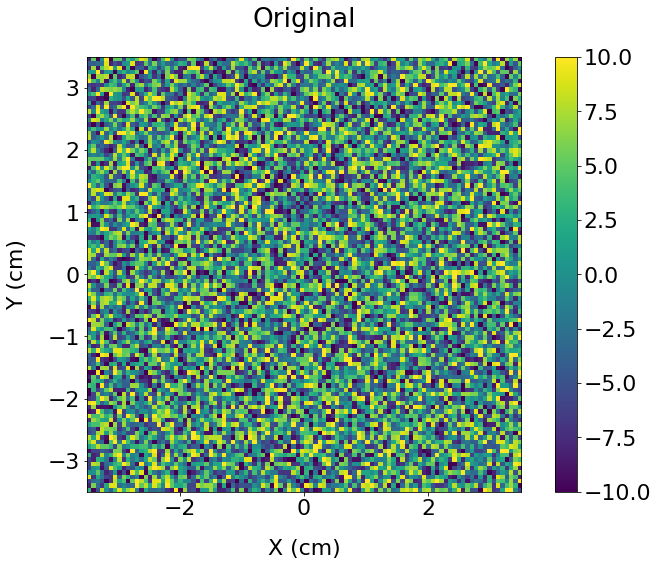

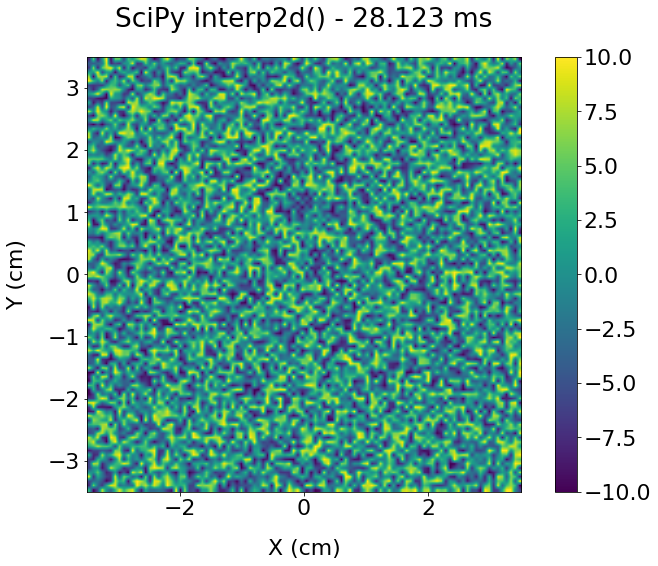

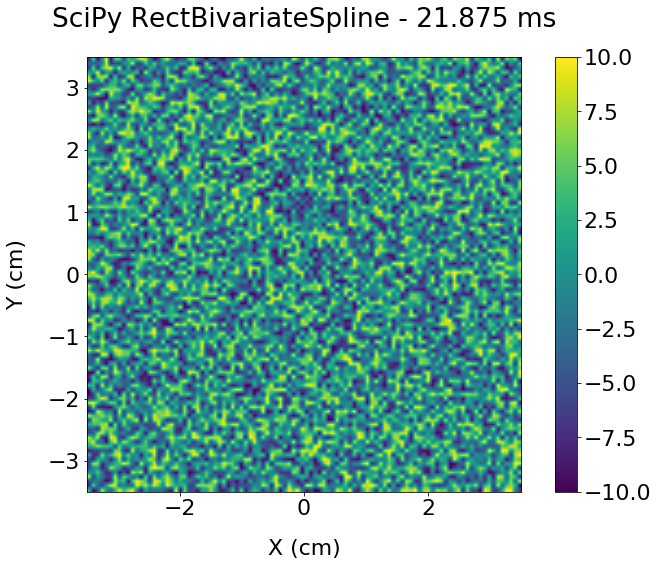

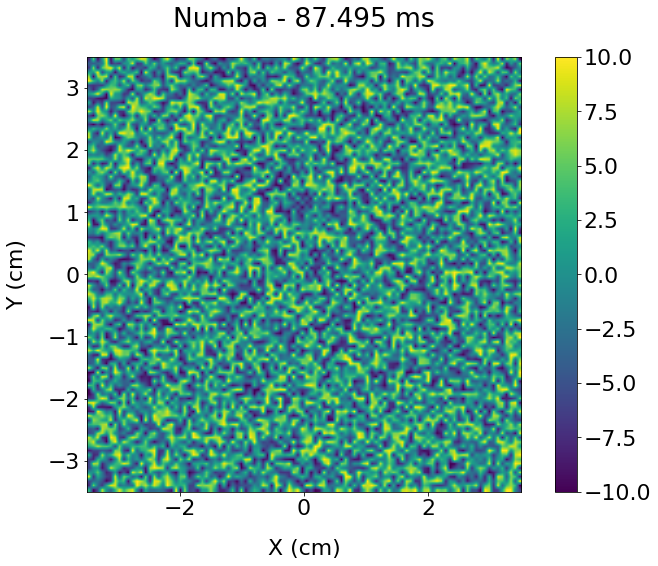

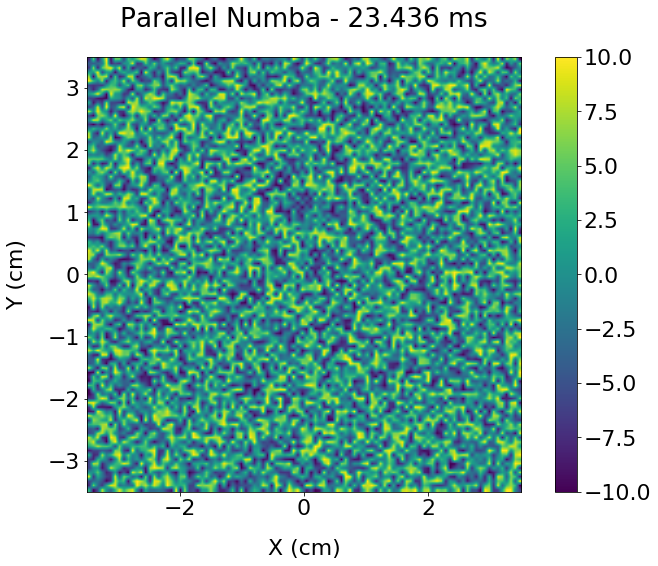

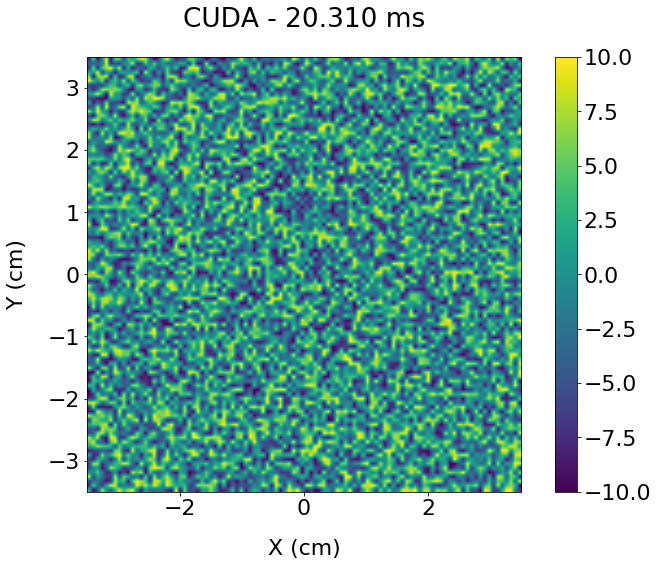

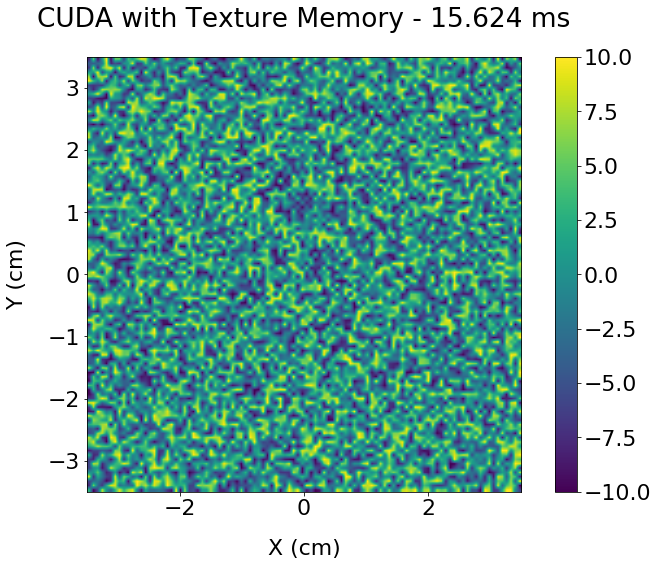

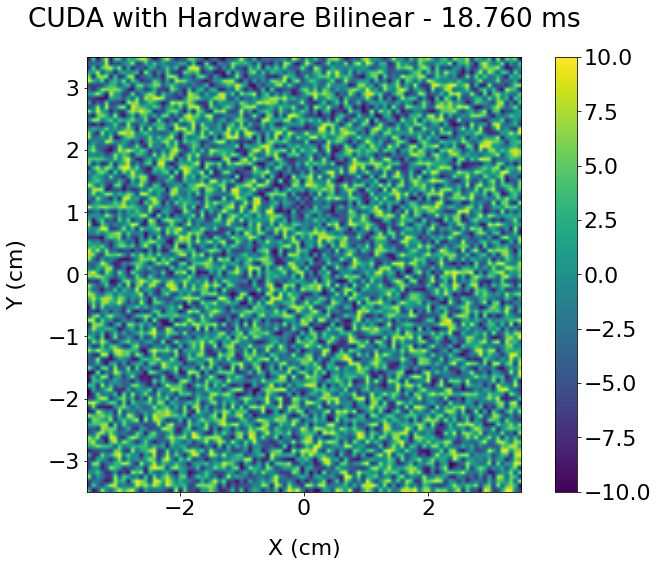

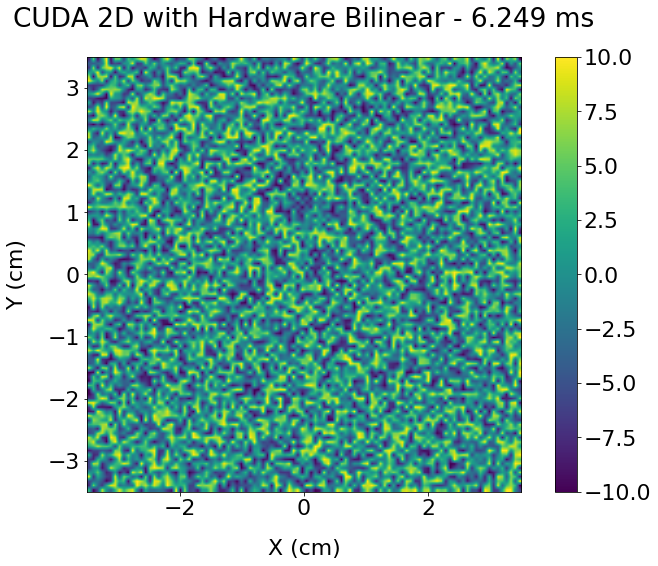

In [8]:
def test_bilinear():
    def plot_result(image, extent, title='', vmin=-10, vmax=10):
        plt.figure()
        plt.imshow(image, extent=extent, origin='lower', vmin=vmin, vmax=vmax)
        plt.xlabel('X (cm)')
        plt.ylabel('Y (cm)')
        plt.title(title)
        plt.colorbar()
        
    from scipy import interpolate

    image = np.random.randint(-10, 10+1, (100, 100)).astype(np.float32)
    extent = np.array([-3.5, 3.5, -3.5, 3.5]).astype(np.float32)

    dx = (extent[1] - extent[0]) / image.shape[0]
    dy = (extent[3] - extent[2]) / image.shape[1]
    minx = extent[0] + dx / 2
    miny = extent[2] + dy / 2
    maxx = extent[1] - dx / 2
    maxy = extent[3] - dy / 2
    
    image_xs = np.linspace(minx, maxx, image.shape[1])
    image_ys = np.linspace(miny, maxy, image.shape[0])
    
    plot_result(image, extent, 'Original')
    
    nx, ny = 5000, 5000
    
    xs = np.linspace(extent[0], extent[1], nx, dtype=np.float32)
    ys = np.linspace(extent[2], extent[3], ny, dtype=np.float32)
    xs_, ys_ = np.meshgrid(xs, ys)
    xs_ = xs_.flatten().astype(np.float32)
    ys_ = ys_.flatten().astype(np.float32)

    # SciPy 2D Interpolate
    f = interpolate.interp2d(image_xs, image_ys, image, kind='linear')
    start_time = time.time()
    scipy_zs = f(xs, ys)
    elapsed_time = time.time() - start_time
    
    plot_result(scipy_zs, extent, f'SciPy interp2d() - {100 * elapsed_time:.3f} ms')
    
    # SciPy RectBivariate Spline
    f = interpolate.RectBivariateSpline(image_xs, image_ys, image, kx=1, ky=1)
    start_time = time.time()
    scipyrect_zs = f(xs, ys)
    elapsed_time = time.time() - start_time   
    
    plot_result(scipyrect_zs, extent, f'SciPy RectBivariateSpline - {100 * elapsed_time:.3f} ms')
    
    # Numba
    numba_zs = np.zeros((nx * ny), dtype=np.float32)
    
    start_time = time.time()
    cpu_bilinear_interpolate(xs_, ys_, image, extent, numba_zs)
    elapsed_time = time.time() - start_time
    
    numba_zs = numba_zs.reshape(ny, nx)
    plot_result(numba_zs, extent, f'Numba - {100 * elapsed_time:.3f} ms')
    
    # Parallel Numba
    pnumba_zs = np.zeros((nx * ny), dtype=np.float32)
    
    start_time = time.time()
    cpu_parallel_bilinear_interpolate(xs_, ys_, image, extent, pnumba_zs)
    elapsed_time = time.time() - start_time
    
    pnumba_zs = pnumba_zs.reshape(ny, nx)
    plot_result(pnumba_zs, extent, f'Parallel Numba - {100 * elapsed_time:.3f} ms')
    
    # Simple CUDA
    cuda_zs = np.zeros((nx * ny), dtype=np.float32)
    elapsed_time = cuda_bilinear_interpolate(xs_, ys_, cuda_zs, image, extent)
    cuda_zs = cuda_zs.reshape(ny, nx)
    plot_result(cuda_zs, extent, f'CUDA - {100 * elapsed_time:.3f} ms')
    
    # CUDA with Textures
    cudatex_zs = np.zeros((nx * ny), dtype=np.float32)
    elapsed_time = cuda_tex_bilinear_interpolate(xs_, ys_, cudatex_zs, image, extent)
    cudatex_zs = cudatex_zs.reshape(ny, nx)
    plot_result(cudatex_zs, extent, f'CUDA with Texture Memory - {100 * elapsed_time:.3f} ms')   
    
    # CUDA hardware bilinear
    cudahd_zs = np.zeros((nx * ny), dtype=np.float32)
    elapsed_time = cuda_hd_bilinear_interpolate(xs_, ys_, cudahd_zs, image, extent)
    cudahd_zs = cudahd_zs.reshape(ny, nx)
    plot_result(cudahd_zs, extent, f'CUDA with Hardware Bilinear - {100 * elapsed_time:.3f} ms', vmin=None, vmax=None)   
    
    # CUDA 2D hardware bilinear
    cuda2Dhd_zs = np.zeros((nx * ny), dtype=np.float32)
    elapsed_time = cuda2D_hd_bilinear_interpolate(xs, ys, cuda2Dhd_zs, image, extent)
    cuda2Dhd_zs = cuda2Dhd_zs.reshape(ny, nx)
    plot_result(cuda2Dhd_zs, extent, f'CUDA 2D with Hardware Bilinear - {100 * elapsed_time:.3f} ms', vmin=None, vmax=None)   
    
    plt.show()
    
test_bilinear()